In [28]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Mouse Signals
## TODO:
 1. Analyze the protocol, byte level.
 

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# PCK Imports

In [2]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import re as re
%matplotlib inline

mpl.rcParams['axes.titlesize']=30
mpl.rcParams['legend.fontsize']=20
mpl.rcParams['text.usetex']=True
mpl.rcParams['axes.grid']=True
path='./Resources/Aquisition/'

# Data Imports

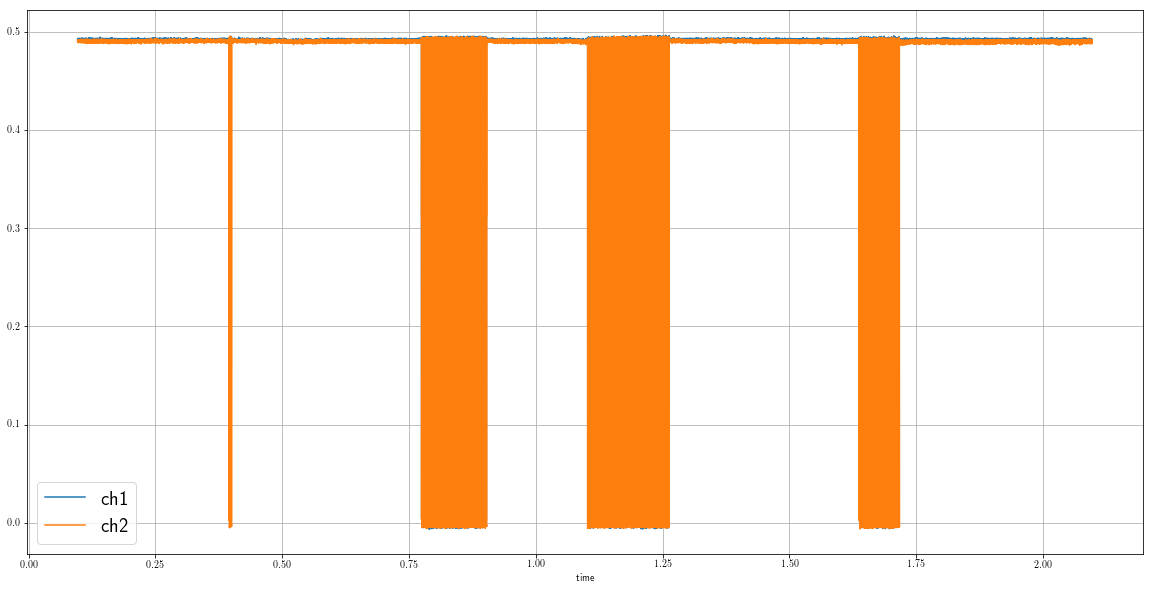

In [3]:
# import del secondo set di dati
t1=pd.read_csv(path+'scope_1_1.csv',usecols=[0,1],names=["time","ch1"],dtype=np.float64,skiprows=2)
t2=pd.read_csv(path+'scope_1_2.csv',usecols=[0,1],names=["time","ch2"],dtype=np.float64,skiprows=2)
tt=pd.DataFrame({'time':t1['time'],'ch1':t1['ch1'],'ch2':t2['ch2']})
dati2=tt.set_index('time')
dati2.plot(figsize=(20,10))

In [5]:
# treeshold for distinguish between 0 and 1. Is not 0.5 because sometimes
# there are spikes from 0 to ~0.6
sogliaTTL=0.7*(5/10)
data=dati2['ch1'].values
clock=dati2['ch2'].values

# Creation of a pandas DF with boolean arrays
data=data>sogliaTTL
clock=clock>sogliaTTL
dati2Digital=pd.DataFrame({'data':data, 'clock':clock},index=dati2.index,dtype=np.int64)

#dati2Digital.plot(figsize=(20,10)) # contains digitalized data, array of bool
#dati2Digital.iloc[28000]

# Classes (that is) code that parses input

## Timing (def constants) and Others
They are not all implemented in the code, but only the ones realy important. Timing is crucial to have the protocol working.

In [6]:
muS=10**-6 # this is a uS
Tsampling=10*muS
Tclk=80*muS
Tclkduty=Tclk/2
TclkHb4CtTx=50*muS
TminCD=5*muS
TminDC=5*muS
TmaxDC=25*muS
TClkL4inh=100*muS
Tmax4CtGenClkPulses=15*10**3*muS
Tmax4PcktSending=2*10**3*muS
TmaxCtResponse=20*10**3*muS

## now i want these timings expressed as sampling time
# the names below can be obtained as (SHELL):
# cat <the_precedent_as_a_file> | gawk -v FS="=" '{print $1;}' | sed s/^T/t/
# the final is
# parallel echo {1}={2}/{3} ::::+ <result of precedent> ::::+  <(cat <result> | gawk -v FS="=" '{print $1;}') ::: Tsampling

tsampling=Tsampling/Tsampling
tclk=Tclk/Tsampling
tclkduty=Tclkduty/Tsampling
tclkHb4CtTx=TclkHb4CtTx/Tsampling
tminCD=np.ceil(TminCD/Tsampling)
tminDC=np.ceil(TminDC/Tsampling)
tmaxDC=np.ceil(TmaxDC/Tsampling)
tClkL4inh=TClkL4inh/Tsampling
tmax4CtGenClkPulses=Tmax4CtGenClkPulses/Tsampling
tmax4PcktSending=Tmax4PcktSending/Tsampling
tmaxCtResponse=TmaxCtResponse/Tsampling

(tsampling ,tclk ,tclkduty ,tclkHb4CtTx ,tminCD ,tminDC ,tmaxDC ,tClkL4inh ,tmax4CtGenClkPulses ,tmax4PcktSending ,tmaxCtResponse)

(1.0,
 8.0,
 4.0,
 5.0,
 1.0,
 1.0,
 3.0,
 10.0,
 1500.0,
 200.00000000000003,
 2000.0000000000002)

In [7]:
# Useful constants to de-clobber the code
HH=(True,True)
HL=(True,False)
LH=(False,True)
LL=(False,False)
H=True
L=False

## Class **readSig**
### idea
To read the signal i've implemented this class. The idea is to reason in a way similar to what the fpga will do. So the signals are read one clock pulse at a time. The object readSig contain the **status** of the object and the signals sent on the transmission line (**clock** and **data**). The global status is made of:
 1. **clock** and **data** @ t
 2. **clock** and **data** @ t-1
 3. **counters**
 4. **status** used to implement a state machine

The method tick() make one tick of the clock. The status is updated, based on 1., 2., 3. and 4. Bits can be readed and put in a buffer. At the end of a packet the buffer is flushed into a collection of packets.
### counters
Counters are needed to measure time intervals. As said before timing is crucial for the protocol, and intervals themselves are part of the global status. For the implementation, instead of just have a variable incremented and a lot of if to check the value, I've written the class Counter, which, to some extent, resembles a real digital counter.
### status
Interesting enough the states of the state machine used are a bit different of the ones I've first tought:
 - **idle**: the status with clock and data high in which host and device are idle. It waits for:
  1. data falling edge -> switch to **dhc**;
  2. clock falling edge -> switch to **waitDevClock**.
 - **dhc**: the status in which device is transmitting data. At the end switch to **endComm**.
 - **hdc**: the status in which host is transmitting. At the end switch to **endComm**.
 - **endComm**: just after the last bit has been transmitted, there is a waiting time and then the idle state which need to be mantained for some time. This is needed because the clock can make some more cycles before being released (1, 2) and I don't want any read obviously. After that switch to **idle**.
 - **waitDevClock**: waits 100uS for the clock to remain low, in order to reasonably assume that the host want communicate with the device. It then goes into **hdc**.
The states **idle**, **dhc**, **hdc** are somewhat the ones expected. **endComm** coul be attached to **dhc** and **hdc** but with duplication of code, and nevertheless is a common path for both communication directions. **waitDevClock** could be attached at **hdc** but keeping it separate, make **hdc** similar to **dhc**, since the waitDevClock is just a particularity of the host to device communication. It makes the code more organized too.

In [8]:
class readSig():
    def __init__(self,clock,data,start=0):
        self.t=counter(len(clock),count=start)
        
        self.C=True
        self.D=True
        self.Co=True
        self.Do=True
        self.CDo=(self.Co,self.Do) # start in pause state
        self.CD=(self.C,self.D)
        
        self.buf=[]
        self.clock=clock
        self.data=data
        self.status='idle'
        self.counters={}
        self.packets=[]
        
        self.counters['endPacket']=counter(6,en=False) # the time for this counter is up to me
        self.counters['endCom']=counter(2,en=False)     # the time for this counter is up to me
        self.counters['tClkL4inh']=counter(tClkL4inh,en=False)
        self.counters['maxTbetweenClock']=counter(20,en=False)
         
    def tick(s):
        ##tmp for solve problem!
        if (len(s.packets)==55):
            pass
            #print(s.t.count)
        ##
        
        ## INITIALIZATION
        # first upload t, C_lock-D_ata-s_tatus, and all counters
        s.t.inc()
        
        s.C=s.clock[s.t.count]
        s.D=s.data[s.t.count]
        s.CD=(s.C,s.D)
        
        # increments all counters
        for k in s.counters:
            s.counters[k].inc()
        
        ## IDLE ##
        # basic status. wait for either a device transmission or host request
        # to transmit.
        if (s.status=='idle'):
            if (s.CD==HH):
                pass
            elif (s.CD==HL):
                s.status='dhc'
                s.counters['tminDC']=counter(tminDC)
                s.counters['tmaxDC']=counter(tmaxDC)
                s.counters['maxTbetweenClock'].enable()
            elif (s.CD==LH):
                s.status='waitDevClock'
                s.counters['tClkL4inh'].enable()
            else:
                raise ValueError('clock and data changed simultaneously!')
                
        ## DHC ##
        # device to host. 
        elif (s.status=='dhc'):
            #if s.counters['tmaxDC']:
            #    raise CounterError('too much time from data low and clock')
            if s.counters['maxTbetweenClock']:
                raise CounterError('too much time between 2 bits, something went wrong?')
                
            if (len(s.buf)<11):
                if (s.Co and not s.C):
                    s.buf.append(s.D)
                    #s.counters['tmaxDC'].hreset()    
                    s.counters['maxTbetweenClock'].reset()
                if (s.Co and s.C):
                    pass
                if (not s.Co and not s.C):
                    pass
                if (not s.Co and s.C):
                    pass
            else:
                s.status='endCom'
                #s.counters['endCom'].enable()
                s.counters['endPacket'].enable()
                s.counters['maxTbetweenClock'].hreset()
                
        ## ENDCOM ##
        elif (s.status=='endCom'):
            if (s.counters['endPacket']):
                s.counters['endCom'].enable()
                if (s.counters['endCom'] and s.C and s.D):
                    s.status='idle'
                    s.packets.append(s.buf)
                    s.buf=[]
                    s.counters['endCom'].hreset()
                    s.counters['endPacket'].hreset()
                if not(s.C and s.D):
                    s.counters['endCom'].reset()
                else:
                    pass
            else:
                pass
            
            # previous version, uses only endcom and not endpacket
            '''# Wait for clock and data to be both high for a defined amount
            # of time which is 10ticks. then flush the buf, hreset the counter
            # and put in idle state, ready to receive other packets.
            elif (s.status=='endCom'):
                if (s.counters['endCom'] and s.C and s.D):
                    s.status='idle'
                    s.packets.append(s.buf)
                    s.buf=[]
                    s.counters['endCom'].hreset()
                if not(s.C and s.D):
                    s.counters['endCom'].reset()
                else:
                    pass'''
            # old version if the precedent should hav problems
            # simply i count 10 ticks but suddenly, that is i
            # don't wait for clock and data to be and remain high
            '''if (s.counters['endCom'] and s.C and s.D):
                s.status='idle'
                s.packets.append(s.buf)
                s.buf=[]
                s.counters['endCom'].hreset()'''
        ## WAITDEVCLOCK ##
        # wait for 100uS and make sure the clock remain low. If not raise error
        # if all goes well switch to 'hdc' status
        elif (s.status=='waitDevClock'):
            if (s.counters['tClkL4inh'] and not s.C):
                s.counters['tClkL4inh'].hreset()
                s.status='hdc'
            elif (s.C):
                raise ValueError('Clock non tenuto basso per 100uS')
            else:
                pass
            
        ## HDC ##
        # Read the first 11 bits on clock rising edge, and the ack on falling
        # edge, then switch to 'endCom' status. The 'Ack' bit is read on falling edge,
        # so data should change between the rising edge of the 11th bit and the falling
        # edge of the 12th aka 'Ack' bit. Instead it happens that data change is in 
        # advance and the stop_bit is read too late. For this reason the 11th aka stop_bit
        # is read using old data.
        elif (s.status=='hdc'):
            if s.counters['maxTbetweenClock']:
                raise CounterError('too much time between 2 bits, something went wrong?')
            if (len(s.buf)<11):
                if (not s.Co and s.C): #fronte di salita
                    s.buf.append(s.Do if (len(s.buf)==10) else s.D ) # explained above
                    s.counters['maxTbetweenClock'].reset()
                    s.counters['maxTbetweenClock'].enable()
                else:
                    pass # then i would implement counters activation here
            else: # it remains to read the ack
                if (s.Co and not s.C):
                    s.buf.append(s.D) 
                    s.status='endCom'
                    #s.counters['endCom'].enable()
                    s.counters['endPacket'].enable()
                    s.counters['maxTbetweenClock'].hreset()
                else:
                    pass
            #return
        else:
            raise ValueError('status is not defined: %s \n I shouldn\'t be here!'%(s.status))
            #return
        
        ## GENERATE OLD ##
        s.Co=s.C    
        s.Do=s.D
        s.CDo=s.CD
        
        ## FINE TICK ##

## END READ SIG        

## Class **packet**
this class implement a packet. The communication will be an array of packets. In the packet there is the information about, the data sended, the meaning, the direction (dev to host or viceversa), binary representation and hex representation. Using ____str____ the contents of the packet are represented in a nice and human readable form. Initially, i create the packet with just the byte and then the extractInfo method extract all the... info:
 1. from the length infer the direction;
 2. check for ACK bit, start, stop, parity. Return the "spoiled" byte;
 3. reverse order, make a binary string and an hex string
 4. apply the dictionary translator for packets, for extracting the meaning

In [9]:
class packet():
    def __init__(self,byte,direction='',mean='',dizD2H={},dizH2D={}):
        self.byte=byte
        self.direction=direction # H2D or D2H
        self.mean=mean
        self.dizD2H=dizD2H
        self.dizH2D=dizH2D
        self.hex=''
        self.bin=''
        
    def __str__(self):        
        string=self.direction
        strDir= '=>' if (self.direction=='H2D') else '<='
        string=string+strDir+' hex:%4s '%(self.hex)+'\tmean: %16s %2s'%(self.mean,strDir)+'\tBYTE: '+self.bin
        return string
    
    def __repr__(self):
        return packet.__str__(self)
    
    def extractInfo(s):
        if (len(s.byte)==11):
            s.direction='D2H'
            s.byte=s.extract(s.byte)
            # here dict
            
        elif (len(s.byte)==12):
            s.direction='H2D'
            if (s.byte[-1]):
                raise ValueError('in H2D ack bit is wrong')
            else:
                s.byte=s.extract(s.byte[0:-1])
            # here dict
        elif (len(s.byte)==8):
            pass
        else:
            raise ValueError('lenght of a packet is wrong!')
        
        # write bin and hex
        s.binAndHex()
        
        # write the meaning
        s.meaning()
        
        return s
        
    def extract(s,byte):
        if (byte[0] or  not byte[-1]):
            raise ValueError('start or stop bits wrong!\nbyte:%s'%(byte))
        else:
            byte=byte[1:-1]
        
        if (not sum(byte)):
            raise ValueError('parità sbagliata')
        else:
            byte=byte[0:-1]
            
        byte.reverse()
        return byte
    
    def binAndHex(s):
        s.bin='0b'
        for b in np.array(s.byte,dtype=np.int64):
            s.bin+=str(b)
        
        # the RE simply put an extra 0 on the hex string, otherwise the
        # first one is omitted.
        s.hex=re.sub(r'(?<=0x)([0123456789abcdef]$)',r'0\1',hex(int(s.bin,2)))
        return s
    def meaning(s):
        try:
            if(s.direction=='D2H'):
                s.mean=dizD2H[s.hex]
            elif(s.direction=='H2D'):
                s.mean=dizH2D[s.hex]
            else:
                raise ValueError('direction must be either D2H or H2D, not:%s'%(s.direction))
        except KeyError as e:
            s.mean=''
        finally:
            return s

## Class **counter**
The motivation is to have an object similar to what the fpga can do. A counter object is created with the limit built-in. The method inc() increment the counter. If the counter reach the limit the object change status and when evalued as a bool return a True value. If counter is not at limit the bool value is False. The counter can be enabled or disabled.

In [10]:
class CounterError(Exception):
    def __init__(self,msg):
        super().__init__(msg)

class counter():
    def __init__(self,limit,count=0,en=True):
        self.limit=int(limit)
        self.finish=False
        self.count=count
        self.en=en
    def inc(self):
        if (self.en and not self.finish):
            self.count=self.count+1
        if (self.count==self.limit):
            self.finish=True
        return self
    def reset(self):
        self.count=0
        self.finish=False
        return self
    def hreset(self):
        self.en=False
        self.reset()
        return self
    def enable(self):
        self.en=True
    def disable(self):
        self.en=False
    def __bool__(self):
        return (self.finish and self.en)

## Dictionary for translation
Translate between hex codes and human readable instructions.

In [29]:
# utile per fare il dizionario: 
# cat commands | gawk  -v FS="\tNone\t" '{print tolower($1)":"$2}' | sed -E 's/([[:alnum:][:blank:]]+)/\x27\1\x27/g'

dizD2H={
    '0xaa':'Self Test Passed',
    '0xfa':'Ack',
}

dizH2D={
    '0xff':'Reset',
    '0xfe':'Resend',
    '0xf6':'Set Defaults',
    '0xf5':'Disable Data Reporting',
    '0xf4':'Enable Data Reporting',
    '0xf3':'Set Sample Rate',
    '0xf2':'Get Device ID',
    '0xf0':'Set Remote Mode',
    '0xee':'Set Wrap Mode',
    '0xec':'Reset Wrap Mode',
    '0xeb':'Read Data',
    '0xea':'Set Stream Mode',
    '0xe9':'Status Request',
    '0xe8':'Set Resolution',
    '0xe6':'Set Scaling 1:1',
    '0xe7':'Set Scaling 2:1',
    #'0x00':'(SR) 1 count/mm',
    #'0x01':'(SR) 2 count/mm',
    #'0x02':'(SR) 4 count/mm',
    #'0x03':'(SR) 8 count/mm',
}


# Processing the data


## start applying readSig
One only need to call readSig.tick() 200000 times. The remain code is used to **debugging** purpose. I can print status and bits for every tick.

In [26]:
# 29840
# 30069  # first H2D
# dopo 80492 c'è il problematico
# 68077 timeBetween2bits

## finestra in cui stampare
startFin = 69512
rang     = 150
finestra=[startFin,startFin+rang]
#finestra=[68000,68000]

R=readSig(clock,data,start=0)
for i in range(199999): #80700
    try:
        R.tick()
    except Exception as e:
        print (e, ' at: %d',R.t.count)
        pass
    
    if (i>finestra[0] and i<finestra[1]):
        pass
        #print('i=%3d, count=%d, status= %12s, C=%d, D=%d, buf=%25s, lbuf=%d, pck=%d'%(i,R.t.count,R.status,R.C,R.D,np.array(R.buf,dtype=np.int64),len(R.buf),len(R.packets)))
    if (R.t.count == 199999):
        break
    #if (len(R.packets)==17):
     #   pass
        #print(R.t.count) 
    
    #if (R.status != 'idle'):
    #    print (R.t.count)
    #   break
    
len(R.packets)


280

In [15]:
## plot data in finestra, if you need to
#dati2Digital.iloc[list(range(finestra[0],finestra[1]))].plot(figsize=(20,10))
#dati2.iloc[list(range(finestra[0],finestra[1]))].plot(figsize=(20,10))

In [44]:
P=[]
Pp=[] # P problematici
for i,p in enumerate(R.packets):
    try:
        P.append(packet(p,dizD2H=dizD2H,dizH2D=dizH2D).extractInfo())
    except Exception as e:
        print(e, 'at:%d',i)
        Pp.append(i)

print('readed %d packets, of which %d are problematic (problematic means found an exception)\n'%(len(P),len(Pp)))

# and print them
for i,p in enumerate(P):
    pass
    print(i, ' ', p)


readed 280 packets, of which 0 are problematic (problematic means found an exception)

0   D2H<= hex:0xaa 	mean: Self Test Passed <=	BYTE: 0b10101010
1   D2H<= hex:0x00 	mean:                  <=	BYTE: 0b00000000
2   H2D=> hex:0xff 	mean:            Reset =>	BYTE: 0b11111111
3   D2H<= hex:0xfa 	mean:              Ack <=	BYTE: 0b11111010
4   D2H<= hex:0xaa 	mean: Self Test Passed <=	BYTE: 0b10101010
5   D2H<= hex:0x00 	mean:                  <=	BYTE: 0b00000000
6   H2D=> hex:0xf2 	mean:    Get Device ID =>	BYTE: 0b11110010
7   D2H<= hex:0xfa 	mean:              Ack <=	BYTE: 0b11111010
8   D2H<= hex:0x00 	mean:                  <=	BYTE: 0b00000000
9   H2D=> hex:0xf6 	mean:     Set Defaults =>	BYTE: 0b11110110
10   D2H<= hex:0xfa 	mean:              Ack <=	BYTE: 0b11111010
11   H2D=> hex:0xf3 	mean:  Set Sample Rate =>	BYTE: 0b11110011
12   D2H<= hex:0xfa 	mean:              Ack <=	BYTE: 0b11111010
13   H2D=> hex:0x0a 	mean:                  =>	BYTE: 0b00001010
14   D2H<= hex:0xfa 	mean: 

# Below exp cells and bin cells

In [41]:
class comm():
    
    def __init__(s,Packets):
        s.P=Packets
        s.t=counter(len(P))
        s.getValue=True
    
    '''def tick(s):
        sp=s.P[s.t.count]
        if (sp.mean=='Self Test Passed'):
            if (s.P[s.t.count+1].hex=='0x00'):
                s.P[s.t.count+1].mean='dev ID is 0x00'
            else:
                pass
        elif (sp.mean=='Get Device ID' and s.P):
            pass  
        else:
            pass'''

    def scorri(s):
        sp=s.P
        for i in range(len(P)):
            spi=sp[i]
            spi1=sp[i+1]
            spi2=sp[i+2]
            spi3=sp[i+3]
            spi4=sp[i+4]
            if (spi.mean=='Self Test Passed'):
                if (spi1.hex=='0x00'):
                    spi1.mean='dev ID is 0x00'
                else:
                    pass
            elif (spi.mean=='Get Device ID' and spi1.mean=='Ack'):
                spi2.mean='dev ID is %4s'(spi2.hex)
            elif (True):
                pass
            else:
                pass
    def __bool__(s):
        return bool(s.t)
    
    def __str__(s):
        for p in s.P:
            print(p)

In [43]:
c=comm(P)
c.scorri()

print(c)

TypeError: 'str' object is not callable

In [2]:
'''for p in P:
    if (p.mean=='' and p.direction=='H2D'):
        print (p)'''
        
def d(f):
    print(f)

[False, True, True, True, True, True, True, True, True, True, True, False]  at:%d 2
[False, False, True, False, False, True, True, True, True, False, True, False]  at:%d 6
[False, False, True, True, False, True, True, True, True, True, True, False]  at:%d 9
[False, True, True, False, False, True, True, True, True, True, True, False]  at:%d 11
[False, False, True, False, True, False, False, False, False, True, True, False]  at:%d 13
[False, False, False, False, True, False, True, True, True, True, True, False]  at:%d 15
[False, False, False, False, False, False, False, False, False, True, True, False]  at:%d 17
[False, True, True, False, False, True, True, True, True, True, True, False]  at:%d 19
[False, False, False, True, False, True, False, False, False, True, True, False]  at:%d 21
[False, True, True, False, False, True, True, True, True, True, True, False]  at:%d 23
[False, False, False, True, True, True, True, False, False, True, True, False]  at:%d 25
[False, True, True, False, F

In [491]:
for i,p in enumerate(R.packets):
    if len(p)==12:
        pass
        print(p, ' at:%d',i)

[False, True, True, True, True, True, True, True, True, True, True, False]  at:%d 2
[False, False, True, False, False, True, True, True, True, False, True, False]  at:%d 6
[False, False, True, True, False, True, True, True, True, True, True, False]  at:%d 9
[False, True, True, False, False, True, True, True, True, True, True, False]  at:%d 11
[False, False, True, False, True, False, False, False, False, True, True, False]  at:%d 13
[False, False, False, False, True, False, True, True, True, True, True, False]  at:%d 15
[False, False, False, False, False, False, False, False, False, True, True, False]  at:%d 17
[False, True, True, False, False, True, True, True, True, True, True, False]  at:%d 19
[False, False, False, True, False, True, False, False, False, True, True, False]  at:%d 21
[False, True, True, False, False, True, True, True, True, True, True, False]  at:%d 23
[False, False, False, True, True, True, True, False, False, True, True, False]  at:%d 25
[False, True, True, False, F

In [518]:
class prova():
    def met(s):
        print('dio steck')
        print(__class__.cava(s))
    def cava(s):
        print('no no no')

class prova2(prova):
    pass
        

In [522]:
j=prova2()
j.cava()

no no no
